In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

SIMULATION_FOLDER = "C:\\Users\\Admin\\OneDrive - Politecnico di Milano\\phd\\code\\multivariate_hawkes\\data\\simulations"

In [41]:
path = Path(SIMULATION_FOLDER)
method_simulation_subdirs = [
    d
    for d in path.rglob("")
    if d.is_dir()
    and not any(child.is_dir() for child in d.iterdir())
    and "lshade" not in str(d)
]

dfs_list = []
for method_simulation_subdir in method_simulation_subdirs:
    params = method_simulation_subdir.parts[-4:-1]

    dfs = []
    for file in method_simulation_subdir.glob("orderbook_changes_*.tsv"):
        df = pd.read_csv(file, sep="\t")
        df["previous"] = df["real"].shift(1)
        df["filename"] = file.name
        dfs.append(df)

    df = pd.concat(dfs)
    df["real_offset"] = df["real"] - df["previous"]
    df["error"] = (df["real"] - df["predicted"]).abs()
    df["error_relative"] = (
        (df["predicted"] - df["previous"]) / (df["real"] - df["previous"])
    ).abs()
    df["method"] = params[0][0:3]
    df["pair"] = params[1]
    df["param"] = params[2][-3:]

    dfs_list.append(df)

df = pd.concat(dfs_list)
df["method_param"] = df["method"] + "_" + df["param"]
df = df.reset_index(drop=True)
df.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_10584\1790309069.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs)
C:\Users\Admin\AppData\Local\Temp\ipykernel_10584\1790309069.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs)
C:\Users\Admin\AppData\Local\Temp\ipykernel_10584\1790309069.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA 

,real,predicted,previous,filename,real_offset,error,error_relative,method,pair,param,method_param
0,0.029,1.025120,NaN,orderbook_changes_1705356920082_1705353321.tsv,NaN,0.996120,NaN,mov,BTC_USD,120,mov_120
1,0.242,1.251409,0.029,orderbook_changes_1705356920082_1705353321.tsv,0.213,1.009409,5.739008,mov,BTC_USD,120,mov_120
2,0.461,1.453670,0.242,orderbook_changes_1705356920082_1705353321.tsv,0.219,0.992670,5.532741,mov,BTC_USD,120,mov_120
3,0.677,1.662221,0.461,orderbook_changes_1705356920082_1705353321.tsv,0.216,0.985221,5.561209,mov,BTC_USD,120,mov_120
4,0.894,1.867958,0.677,orderbook_changes_1705356920082_1705353321.tsv,0.217,0.973958,5.488287,mov,BTC_USD,120,mov_120


Plot distribution of real offsets between events

<Axes: xlabel='pair', ylabel='log_offset'>

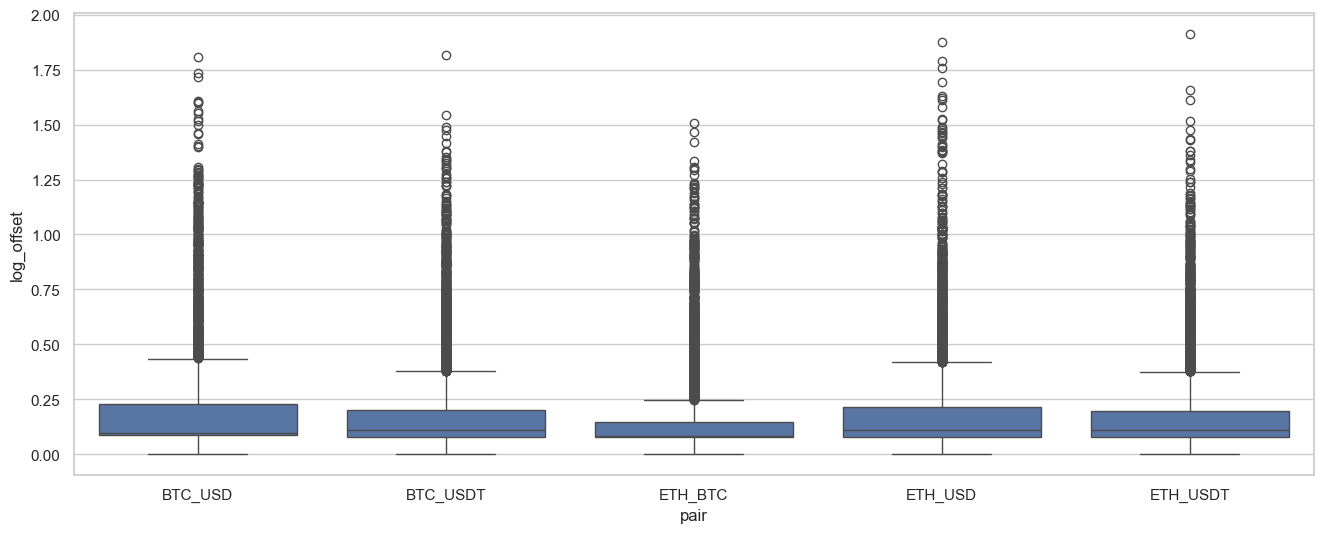

In [42]:
import numpy as np


pair = "BTC_USD"
one_instance_df = df[(df["method_param"] == "mov_120")].copy()
one_instance_df["log_offset"] = one_instance_df["real_offset"].apply(
    lambda x: np.log10(x + 1)
)
sns.set(style="whitegrid")
plt.figure(figsize=(16, 6))
sns.boxplot(x="pair", y="log_offset", data=one_instance_df)

Plot distribution of number of events in each file

<Axes: xlabel='pair', ylabel='real'>

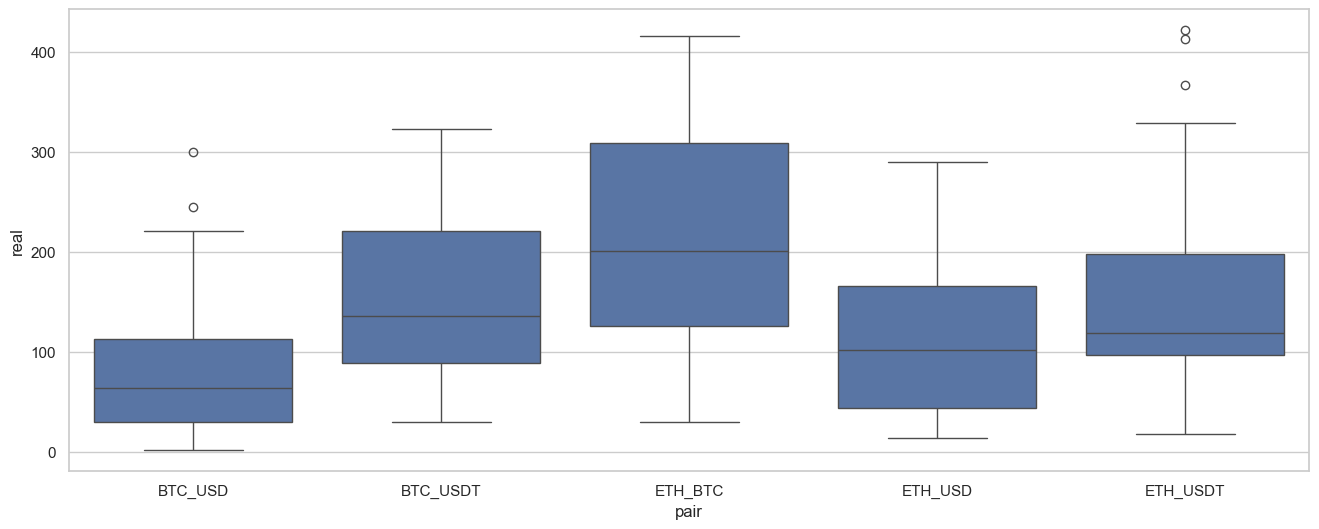

In [43]:
count_df = (
    one_instance_df[["pair", "filename", "real"]]
    .groupby(["pair", "filename"])
    .count()
    .reset_index()
)

sns.set(style="whitegrid")
plt.figure(figsize=(16, 6))
sns.boxplot(x="pair", y="real", data=count_df)

Plot accuracy for BTCUSD only for top 50% of files according to the number of events in each of them

C:\Users\Admin\AppData\Local\Temp\ipykernel_10584\4054623219.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


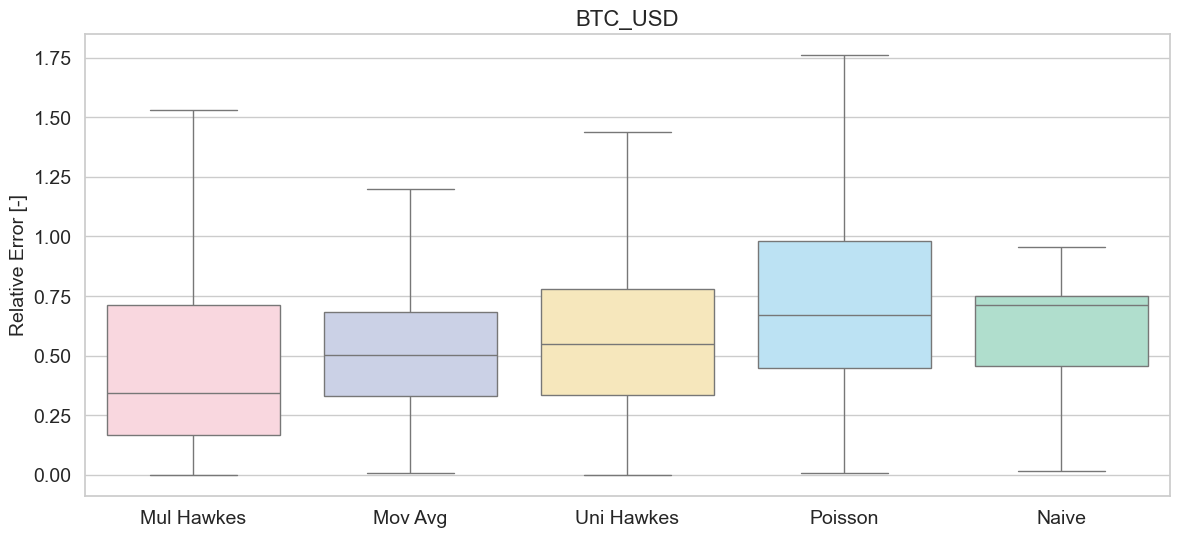

In [44]:
top_files = (
    count_df[count_df["pair"] == pair]
    .sort_values("real", ascending=False)
    .head(25)["filename"]
)
df_pair = df[(df["pair"] == pair) & (df["filename"].isin(top_files))].copy()

best_method_params_for_each_method = (
    df_pair[["method", "error_relative", "method_param"]]
    .groupby(["method", "method_param"])
    .median()
    .sort_values("error_relative")
    .reset_index()
    .drop_duplicates("method", keep="first")
)

df_pair = df_pair.merge(
    best_method_params_for_each_method[["method_param", "method"]],
    on=["method_param", "method"],
    how="inner",
)

df_pair["method"] = df_pair["method"].map(
    {
        "mul": "Mul Hawkes",
        "mov": "Mov Avg",
        "uni": "Uni Hawkes",
        "nai": "Naive",
        "poi": "Poisson",
    }
)

df_pair["error_relative_log"] = df_pair["error_relative"].apply(
    lambda x: np.log10(1 + x)
)

unique_methods = df_pair["method"].sort_values().unique()
colors = (
    ["#C7CEEA"] * 1 + ["#FFD1DC"] * 1 + ["#A8E6CF"] + ["#B3E5FC"] * 1 + ["#FFECB3"] * 1
)

palette = dict(zip(unique_methods, colors))
plt.figure(figsize=(14, 6))
sns.boxplot(
    x="method",
    y="error_relative_log",
    data=df_pair,
    showfliers=False,
    palette=palette,
    order=["Mul Hawkes", "Mov Avg", "Uni Hawkes", "Poisson", "Naive"],
)

# increase the size of the font
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# increase the size of the font for title
plt.title(pair, fontsize=16)


plt.xlabel("")
plt.ylabel("Relative Error [-]", fontsize=14)
plt.show()

Plot training scores for multivariate hawkes 900 training

In [45]:
path = Path(
    "C:\\Users\\Admin\\OneDrive - Politecnico di Milano\\phd\\code\\multivariate_hawkes\\data\\trained_params\\multivariate_hawkes"
)
method_simulation_subdirs = [
    d for d in path.rglob("") if d.is_dir() and d.name == "training_time_900"
]
likelihood_paths = [d / "likelihoods.txt" for d in method_simulation_subdirs]


dfs = []
for file in likelihood_paths:
    df = pd.read_csv(file, sep="\t")
    df["pair"] = file.parts[-3]
    dfs.append(df)

score_df = pd.concat(dfs)
score_df

,file,likelihood,pair
0,data\trained_params\multivariate_hawkes\BTC_US...,1.365431,BTC_USD
1,data\trained_params\multivariate_hawkes\BTC_US...,1.175228,BTC_USD
2,data\trained_params\multivariate_hawkes\BTC_US...,1.277598,BTC_USD
3,data\trained_params\multivariate_hawkes\BTC_US...,1.068823,BTC_USD
4,data\trained_params\multivariate_hawkes\BTC_US...,0.966262,BTC_USD
...,...,...,...
45,data\trained_params\multivariate_hawkes\ETH_US...,1.867951,ETH_USDT
46,data\trained_params\multivariate_hawkes\ETH_US...,1.063131,ETH_USDT
47,data\trained_params\multivariate_hawkes\ETH_US...,1.149654,ETH_USDT
48,data\trained_params\multivariate_hawkes\ETH_US...,1.163473,ETH_USDT


<Axes: xlabel='pair', ylabel='likelihood'>

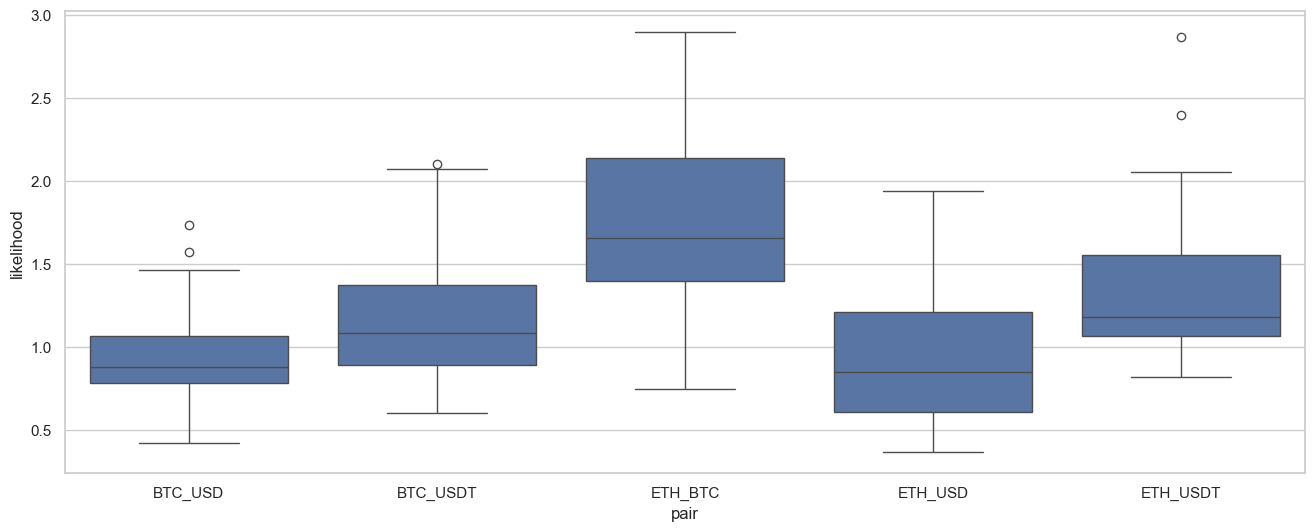

In [46]:
sns.set(style="whitegrid")
plt.figure(figsize=(16, 6))
sns.boxplot(x="pair", y="likelihood", data=score_df)

Plot distribution of coefficents

In [47]:
param_dfs = []
for param in ["alpha", "beta", "mu"]:
    path = Path(
        "C:\\Users\\Admin\\OneDrive - Politecnico di Milano\\phd\\code\\multivariate_hawkes\\data\\trained_params\\multivariate_hawkes"
    )
    param_files = [
        d for d in path.rglob(f"*/training_time_900/*_{param}.txt") if d.is_file()
    ]

    for file in param_files:
        matrix = np.loadtxt(file)
        if param == "mu":
            matrix = matrix.reshape(3, 1)
        n_rows, n_cols = matrix.shape
        row_indices, col_indices = np.indices((n_rows, n_cols))
        values = matrix.flatten()
        df = pd.DataFrame(
            {
                "file": [file.name.split(f"_{param}")[0]] * len(values),
                "param": [param] * len(values),
                "pair": [file.parts[-3]] * len(values),
                "value": values,
                "index": range(len(values)),
                "row_index": row_indices.flatten(),
                "col_index": col_indices.flatten(),
            }
        )
        param_dfs.append(df)

param_df = pd.concat(param_dfs)
param_df

,file,param,pair,value,index,row_index,col_index
0,orderbook_changes_1705356920082_1705353321,alpha,BTC_USD,0.751934,0,0,0
1,orderbook_changes_1705356920082_1705353321,alpha,BTC_USD,0.294363,1,0,1
2,orderbook_changes_1705356920082_1705353321,alpha,BTC_USD,0.000000,2,0,2
3,orderbook_changes_1705356920082_1705353321,alpha,BTC_USD,0.017168,3,1,0
4,orderbook_changes_1705356920082_1705353321,alpha,BTC_USD,0.000000,4,1,1
...,...,...,...,...,...,...,...
1,orderbook_changes_1713823852015_1713820258,mu,ETH_USDT,0.255883,1,1,0
2,orderbook_changes_1713823852015_1713820258,mu,ETH_USDT,0.142731,2,2,0
0,orderbook_changes_1713823852015_1713822178,mu,ETH_USDT,0.184138,0,0,0
1,orderbook_changes_1713823852015_1713822178,mu,ETH_USDT,0.059648,1,1,0


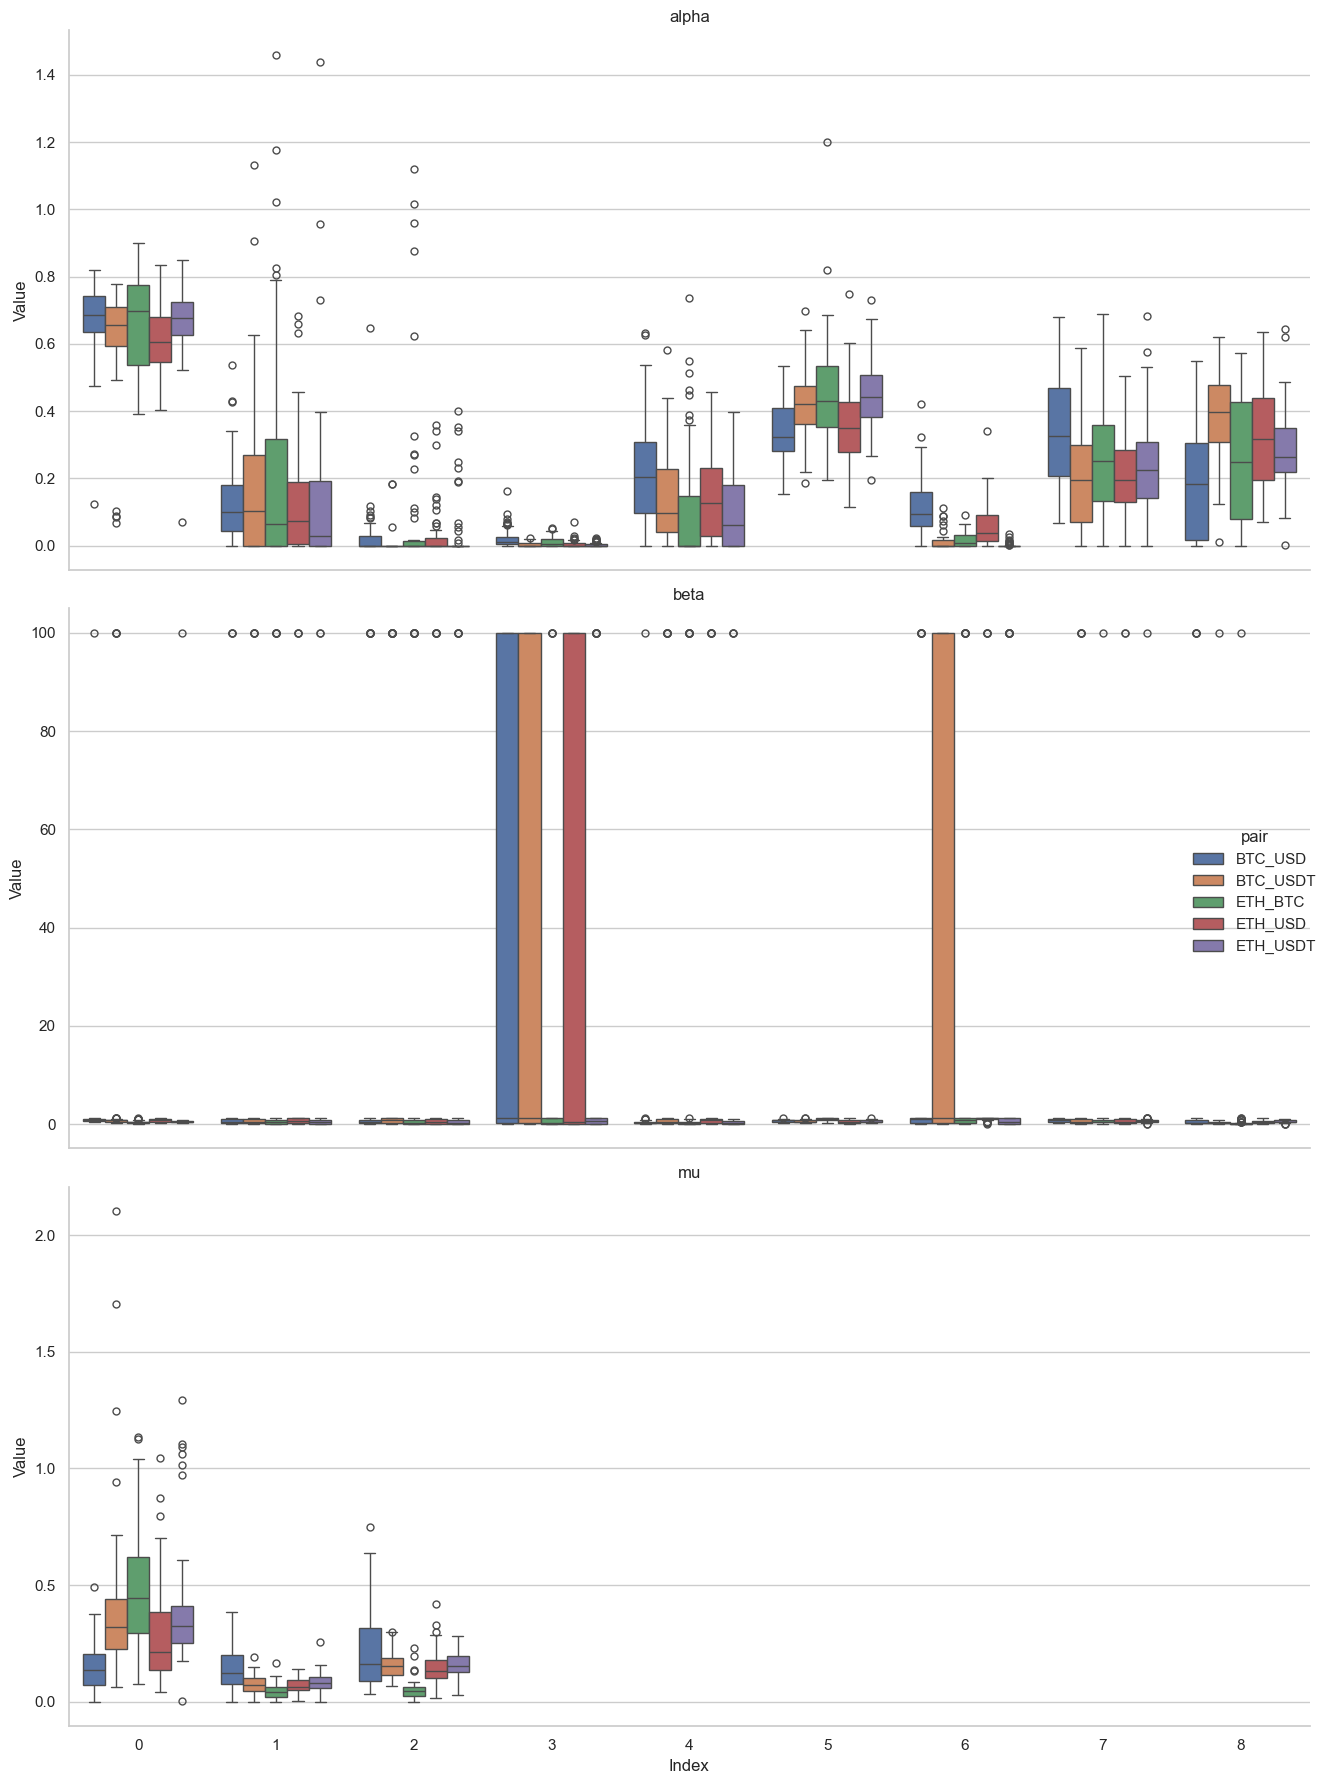

In [9]:
g = sns.catplot(
    data=param_df,
    x="index",
    y="value",
    hue="pair",
    col=None,  # No columns
    row="param",  # Facet by the "param" variable (1 column, 3 rows)
    kind="box",  # Boxplot
    height=6,  # Height of each facet
    aspect=2,  # Aspect ratio of each facet
    sharey=False,  # Share the y-axis between facets
)

# Adjust the plot
g.set_axis_labels("Index", "Value")  # Set axis labels
g.set_titles(
    row_template="{row_name}", col_template="{col_name}"
)  # Title for each facet
plt.tight_layout()  # Prevent overlapping

# Show the plot
plt.show()

<Axes: xlabel='index', ylabel='rho'>

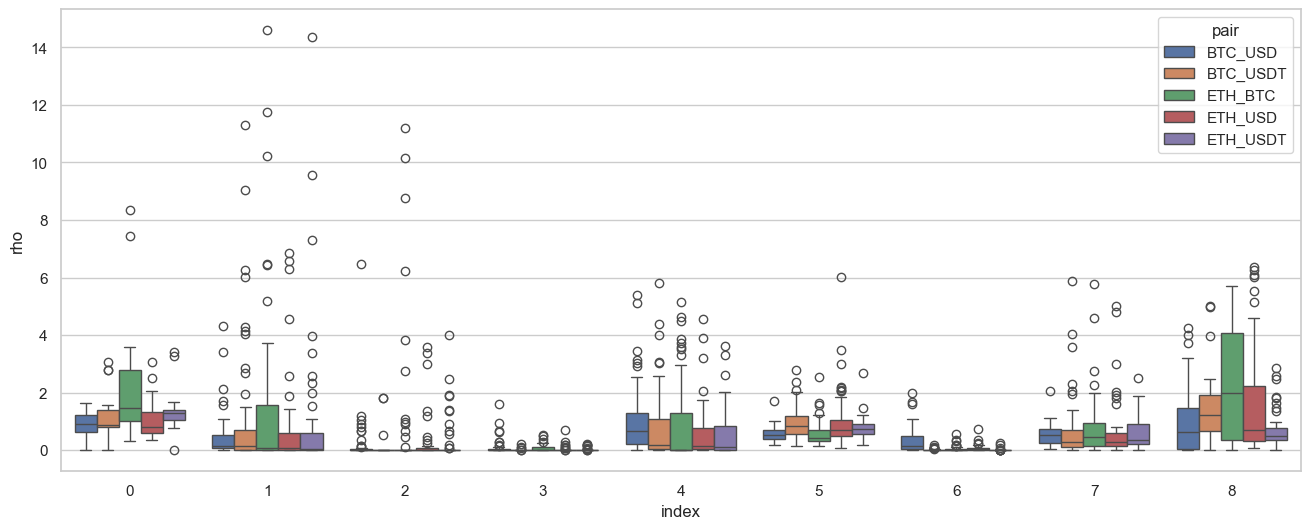

In [48]:
# plot the distribution of rho = alpha/beta
rho_df = param_df[["pair", "file", "index", "value", "param"]]
rho_df = rho_df[rho_df["param"] == "alpha"].merge(
    rho_df[rho_df["param"] == "beta"],
    on=["pair", "file", "index"],
    suffixes=("_alpha", "_beta"),
)
rho_df["rho"] = rho_df["value_alpha"] / rho_df["value_beta"]

sns.set(style="whitegrid")
plt.figure(figsize=(16, 6))
sns.boxplot(x="index", y="rho", data=rho_df, hue="pair")

<Axes: xlabel='value_alpha', ylabel='value_beta'>

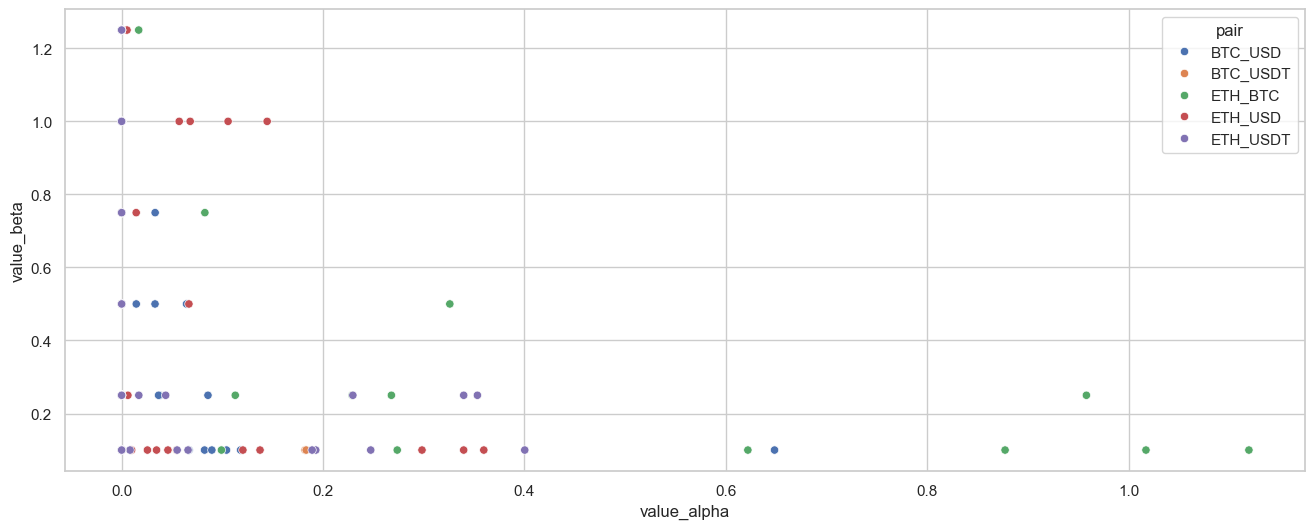

In [18]:
sns.set(style="whitegrid")
plt.figure(figsize=(16, 6))
sns.scatterplot(
    x="value_alpha",
    y="value_beta",
    data=rho_df[(rho_df["index"] == 2) & (rho_df["value_beta"] < 100)],
    hue="pair",
)

In [23]:
param_df[(param_df["param"] == "alpha") & (param_df["value"] == 0)]

,file,param,pair,value,index,row_index,col_index
2,orderbook_changes_1705356920082_1705353321,alpha,BTC_USD,0.0,2,0,2
4,orderbook_changes_1705356920082_1705353321,alpha,BTC_USD,0.0,4,1,1
8,orderbook_changes_1705356920082_1705353321,alpha,BTC_USD,0.0,8,2,2
2,orderbook_changes_1705356920082_1705355241,alpha,BTC_USD,0.0,2,0,2
4,orderbook_changes_1705356920082_1705355241,alpha,BTC_USD,0.0,4,1,1
...,...,...,...,...,...,...,...
6,orderbook_changes_1713823852015_1713820258,alpha,ETH_USDT,0.0,6,2,0
2,orderbook_changes_1713823852015_1713822178,alpha,ETH_USDT,0.0,2,0,2
3,orderbook_changes_1713823852015_1713822178,alpha,ETH_USDT,0.0,3,1,0
4,orderbook_changes_1713823852015_1713822178,alpha,ETH_USDT,0.0,4,1,1


In [29]:
param_df[param_df["param"] == "alpha"].assign(
    is_zero=(param_df[param_df["param"] == "alpha"]["value"] == 0)
)[["pair", "row_index", "col_index", "is_zero"]]

,pair,row_index,col_index,is_zero
0,BTC_USD,0,0,False
1,BTC_USD,0,1,False
2,BTC_USD,0,2,True
3,BTC_USD,1,0,False
4,BTC_USD,1,1,True
...,...,...,...,...
4,ETH_USDT,1,1,True
5,ETH_USDT,1,2,False
6,ETH_USDT,2,0,True
7,ETH_USDT,2,1,False


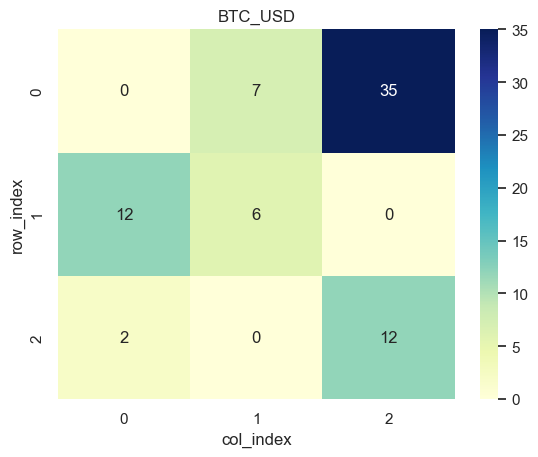

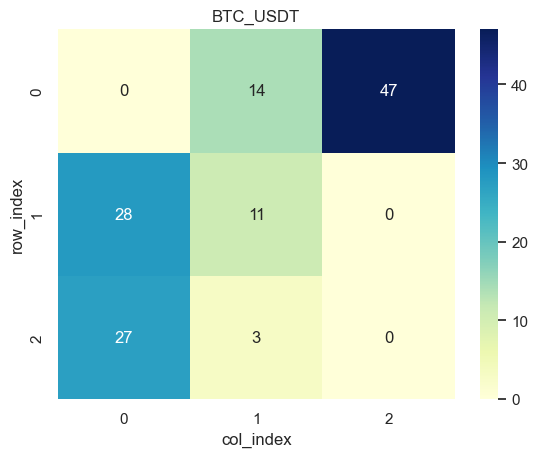

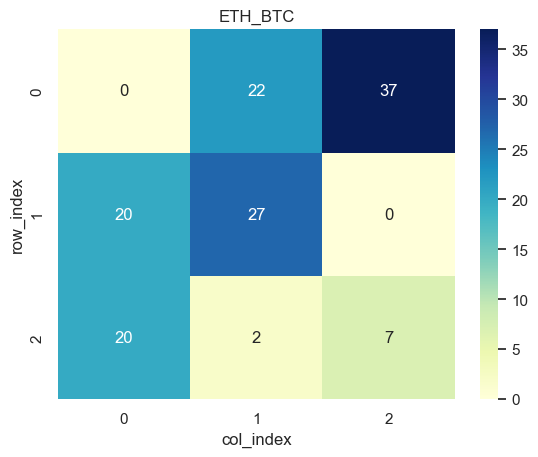

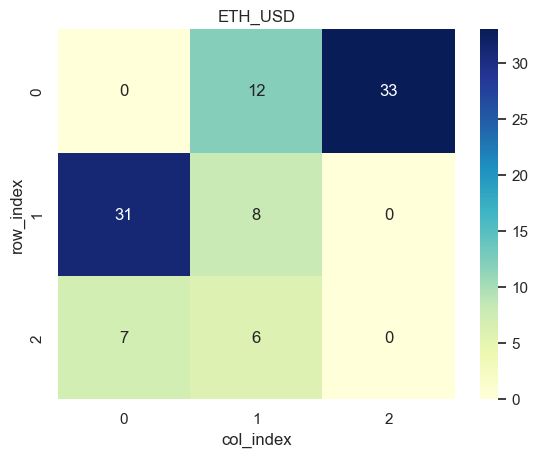

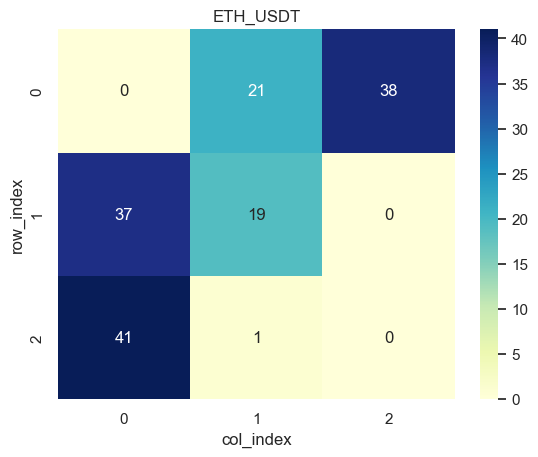

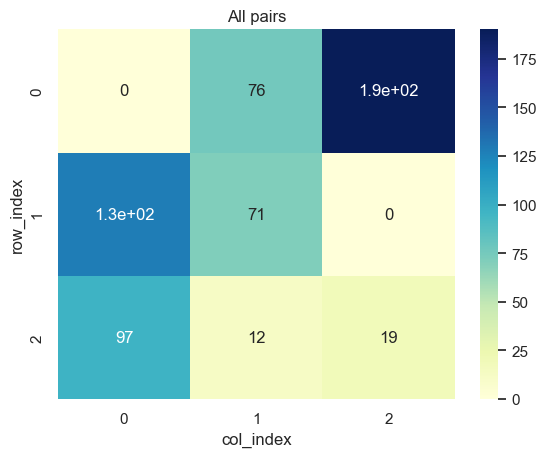

In [32]:
zeros_alpha = (
    param_df[param_df["param"] == "alpha"]
    .assign(is_zero=(param_df[param_df["param"] == "alpha"]["value"] == 0))[
        ["pair", "row_index", "col_index", "is_zero"]
    ]
    .groupby(["pair", "row_index", "col_index"])
    .sum()
    .reset_index()
)

for pair in ["BTC_USD", "BTC_USDT", "ETH_BTC", "ETH_USD", "ETH_USDT"]:
    zeros_alpha_pair = zeros_alpha[zeros_alpha["pair"] == pair]
    heatmap_data = zeros_alpha_pair.pivot(
        index="row_index", columns="col_index", values="is_zero"
    )

    # Plot the heatmap
    sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", cbar=True)
    plt.title(pair)
    plt.show()

heatmap_data = (
    zeros_alpha.groupby(["row_index", "col_index"])
    .sum()
    .reset_index()
    .pivot(index="row_index", columns="col_index", values="is_zero")
)

# Plot the heatmap
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", cbar=True)
plt.title("All pairs")
plt.show()

<Axes: xlabel='pair_index', ylabel='value'>

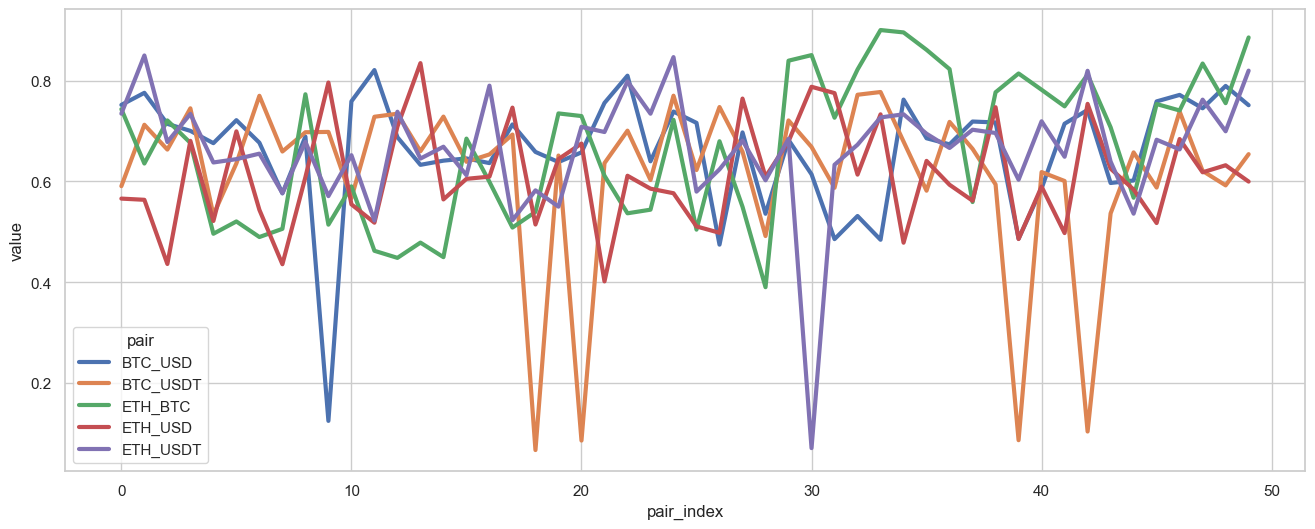

In [39]:
alpha_00 = param_df[
    (param_df["param"] == "alpha") & (param_df["index"] == 0)
].sort_values(["pair", "file"])

# create an index that start from 0 and restart for each pair
alpha_00["pair_index"] = alpha_00.groupby("pair").cumcount()

sns.set(style="whitegrid")
plt.figure(figsize=(16, 6))
sns.lineplot(
    x="pair_index",
    y="value",
    data=alpha_00,
    hue="pair",
    linewidth=3,
)

<Axes: xlabel='pair_index', ylabel='value'>

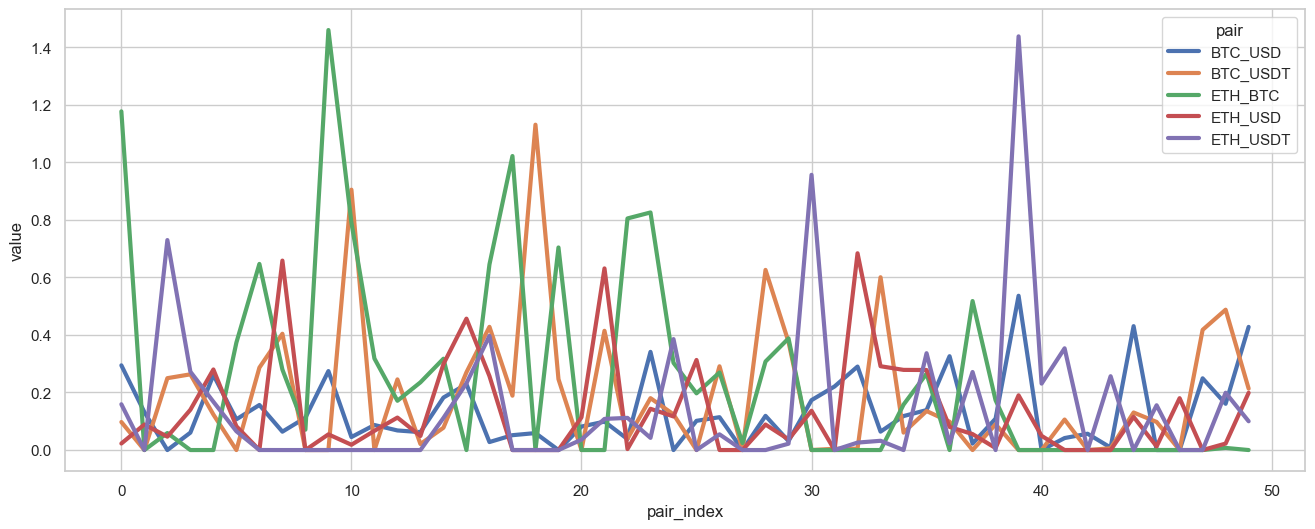

In [40]:
alpha_00 = param_df[
    (param_df["param"] == "alpha") & (param_df["index"] == 1)
].sort_values(["pair", "file"])

# create an index that start from 0 and restart for each pair
alpha_00["pair_index"] = alpha_00.groupby("pair").cumcount()

sns.set(style="whitegrid")
plt.figure(figsize=(16, 6))
sns.lineplot(
    x="pair_index",
    y="value",
    data=alpha_00,
    hue="pair",
    linewidth=3,
)

In [54]:
alpha_00 = param_df[
    (param_df["param"] == "alpha") & (param_df["value"] >= 0)
].sort_values(["pair", "file"])

# create an index that start from 0 and restart for each pair
alpha_00["pair_index"] = alpha_00.groupby("pair").cumcount()
alpha_00["value"].describe()

count    2250.000000
mean        0.222504
std         0.243352
min         0.000000
25%         0.000000
50%         0.139049
75%         0.387318
max         1.459436
Name: value, dtype: float64

Check distributions of events in training time

In [2]:
import os
from typing import Dict, List

import numpy as np
import pandas as pd
import yaml

os.chdir(
    "C:\\Users\\Admin\\OneDrive - Politecnico di Milano\\phd\\code\\multivariate_hawkes\\"
)


import src.constants as CONST
from src.conf.events_conf.events_conf import EventsConf
from src.conf.training.training_conf import TrainingConf
from src.events_extractor.multivariate_lob_events_extractor import (
    MultivariateLOBEventsExtractor,
)
from src.lob_data_loader.loading_info_getter import LoadingInfoGetter
from src.lob_data_loader.lob_data_loader import LOBDataLoader
from src.lob_period.lob_period_extractor import LOBPeriodExtractor
from src.multivariate_hawkes_training.event_type_times_maps_formatter import (
    EventTypeTimesMapsFormatter,
)
from src.multivariate_hawkes_training.lob_event_combinator import LOBEventCombinator

CONF_EVENTS_FILENAME = "mid_price_change_and_sublevels_events_conf.yml"
CONF_TRAINING_FILENAME = "training_conf.yml"


def get_conf(path: str) -> Dict:
    with open(path, "r") as f:
        conf = yaml.safe_load(f)
    return conf


def get_event_type_times_maps_with_combined_types(
    event_type_times_map: List[Dict[str, np.ndarray]],
    combined_name_events_to_combine_map: Dict[str, List[str]],
) -> List[Dict[str, np.ndarray]]:

    lob_event_combinator = LOBEventCombinator([event_type_times_map])

    for (
        combination_name,
        lob_events_to_combine,
    ) in combined_name_events_to_combine_map.items():
        event_type_times_maps = (
            lob_event_combinator.get_event_type_times_maps_with_new_combination(
                lob_events_to_combine,
                combination_name=combination_name,
            )
        )
        lob_event_combinator.event_type_times_maps = event_type_times_maps

    return event_type_times_maps


def get_event_type_times_maps_filtered(
    event_type_times_map: List[Dict[str, np.ndarray]], events_to_compute: List[str]
) -> List[Dict[str, np.ndarray]]:
    return [
        {
            key: value
            for key, value in event_type_times.items()
            if key in events_to_compute
        }
        for event_type_times in event_type_times_map
    ]


if __name__ == "__main__":
    training_conf_map = get_conf(
        os.path.join(CONST.CONF_TRAINING_FOLDER, CONF_TRAINING_FILENAME)
    )
    training_conf = TrainingConf.from_dict(training_conf_map)

    events_conf_map = get_conf(
        os.path.join(CONST.CONF_EVENTS_FOLDER, CONF_EVENTS_FILENAME)
    )
    events_conf = EventsConf.from_dict(events_conf_map)

    for pair in ["BTC_USD", "BTC_USDT", "ETH_BTC", "ETH_USD", "ETH_USDT"]:
        pair_orderbook_changes_path = os.path.join(CONST.ORDERBOOK_CHANGES_FOLDER, pair)
        periods_df = pd.read_csv(
            os.path.join(
                pair_orderbook_changes_path, CONST.SIMULATION_START_TIMESTAMPS_FILE
            )
        )

        loading_info_for_all_dfs = LoadingInfoGetter(periods_df).get_loading_info(
            lob_df_folder_path=pair_orderbook_changes_path,
            lob_df_prefix=CONST.ORDERBOOK_CHANGES_FILE_PREFIX,
        )

        training_time_file_likelihood_map = {
            training_time: {"file": [], "likelihood": []}
            for training_time in training_conf.seconds_in_a_period
        }

        events_map = {
            "pair": [],
            "file": [],
            "event_type": [],
            "event_time": [],
        }

        for loading_info in loading_info_for_all_dfs:
            lob_df_loader = LOBDataLoader()
            lob_df = lob_df_loader.get_lob_dataframe(loading_info.path, 10)

            lob_period_extractor = LOBPeriodExtractor(lob_df)

            for start_simulation_time in loading_info.start_times:
                for training_time_seconds in training_conf.seconds_in_a_period:
                    start_time = start_simulation_time - training_time_seconds

                    end_time = start_simulation_time

                    lob_period = lob_period_extractor.get_lob_period(
                        start_time, end_time
                    )
                    lob_df_for_events = lob_period.get_lob_df_with_timestamp_column()

                    lob_df_for_events["Timestamp"] = (
                        lob_df_for_events["Timestamp"] * 1000
                    )

                    lob_events_extractor = MultivariateLOBEventsExtractor(
                        lob_df_for_events,
                        events_conf.num_levels_in_a_side,
                        events_conf.num_levels_for_which_save_events,
                    )

                    event_type_times_map = lob_events_extractor.get_events()
                    event_type_times_map = {
                        key.name: value for key, value in event_type_times_map.items()
                    }

                    event_type_times_maps = (
                        get_event_type_times_maps_with_combined_types(
                            event_type_times_map, events_conf.combined_event_types_map
                        )
                    )

                    event_type_times_maps = get_event_type_times_maps_filtered(
                        event_type_times_maps, events_conf.events_to_compute
                    )

                    event_type_times_map_formatter = EventTypeTimesMapsFormatter()

                    event_type_times_formatted = (
                        event_type_times_map_formatter.get_events_types_periods(
                            event_type_times_maps, events_conf.events_to_compute
                        )
                    )

                    event_type_times_formatted_in_seconds = [
                        [times / 1000 for times in event_type_times]
                        for event_type_times in event_type_times_formatted
                    ]

                    prefix = os.path.basename(loading_info.path)
                    prefix = os.path.splitext(prefix)[0]

                    for event_type, event_times in zip(
                        events_conf.events_to_compute,
                        event_type_times_formatted_in_seconds[0],
                    ):
                        events_map["pair"].extend([pair] * len(event_times))
                        events_map["file"].extend(
                            [f"{prefix}_{start_simulation_time}"] * len(event_times)
                        )
                        events_map["event_type"].extend([event_type] * len(event_times))
                        events_map["event_time"].extend(event_times)

        events_df = pd.DataFrame(events_map)
        events_df.to_csv(
            os.path.join(
                "C:\\Users\\Admin\\OneDrive - Politecnico di Milano\\phd\\code\\multivariate_hawkes\\notebook\\data",
                f"{pair}_events.csv",
            ),
            index=False,
            sep="\t",
        )

<Axes: xlabel='event_type', ylabel='log_offset'>

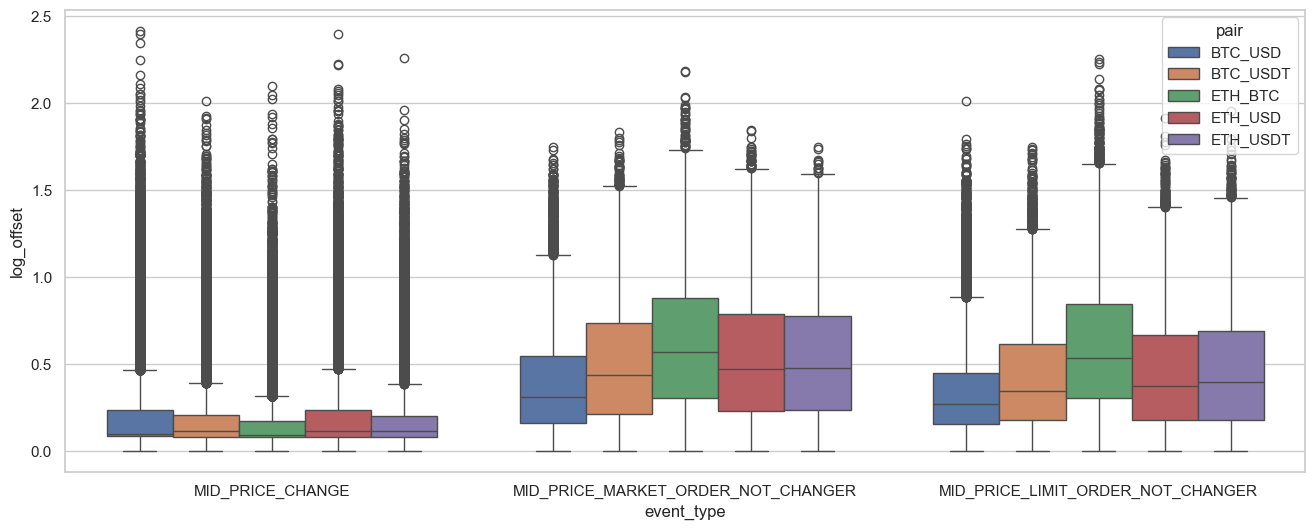

In [19]:
df_events = []
for pair in ["BTC_USD", "BTC_USDT", "ETH_BTC", "ETH_USD", "ETH_USDT"]:
    df = pd.read_csv(
        f"C:\\Users\\Admin\\OneDrive - Politecnico di Milano\\phd\\code\\multivariate_hawkes\\notebook\\data\\{pair}_events.csv",
        sep="\t",
    )

    # compute offset between events but only for each pair, file, and event type
    df["previous"] = df.groupby(["pair", "file", "event_type"])["event_time"].shift(1)
    df["offset"] = df["event_time"] - df["previous"]
    df_events.append(df)

df_events = pd.concat(df_events, ignore_index=True)

df_events["log_offset"] = df_events["offset"].apply(lambda x: np.log10(x + 1))
sns.set(style="whitegrid")
plt.figure(figsize=(16, 6))
sns.boxplot(x="event_type", y="log_offset", data=df_events, hue="pair")

<Axes: xlabel='pair', ylabel='log_offset_all'>

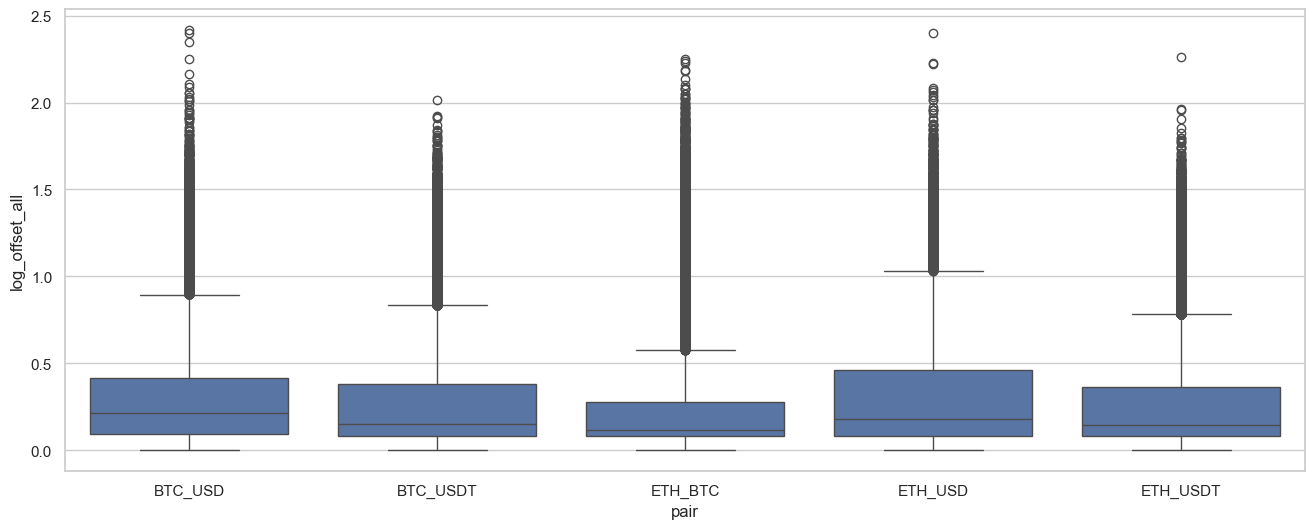

In [22]:
df_events = df_events.sort_values(["pair", "file", "event_time"])
df_events["previous_all"] = df_events.groupby(["pair", "file", "event_type"])[
    "event_time"
].shift(1)
df_events["offset_all"] = df_events["event_time"] - df_events["previous_all"]
df_events["log_offset_all"] = df_events["offset_all"].apply(lambda x: np.log10(x + 1))

sns.set(style="whitegrid")
plt.figure(figsize=(16, 6))
sns.boxplot(x="pair", y="log_offset_all", data=df_events)

<Axes: xlabel='event_type', ylabel='event_time'>

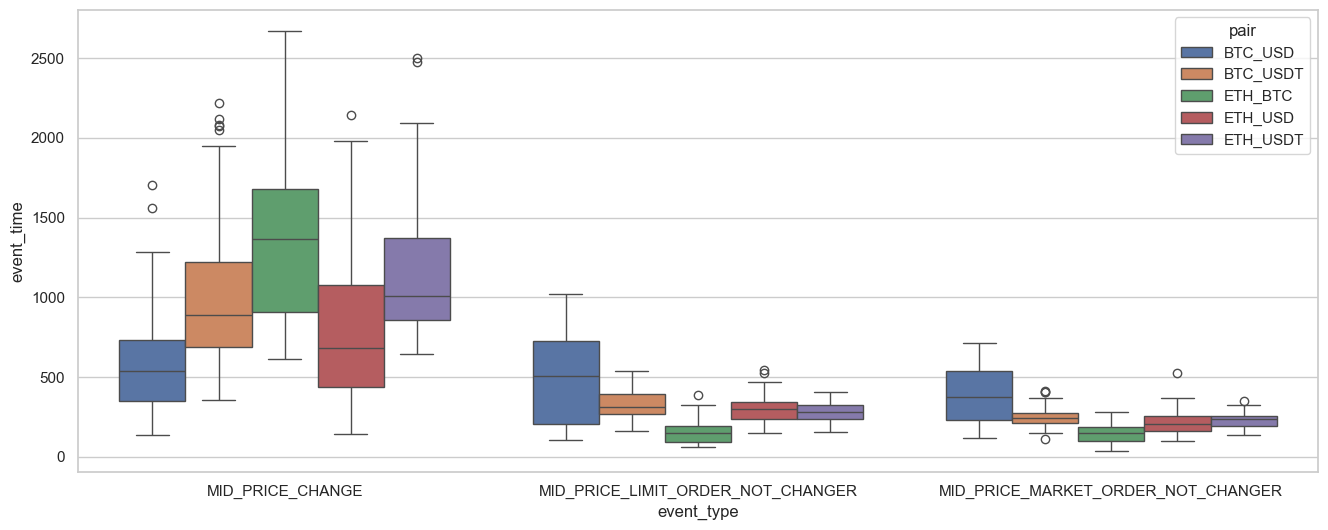

In [26]:
count_df = (
    df_events[["pair", "file", "event_type", "event_time"]]
    .groupby(["pair", "file", "event_type"])
    .count()
    .reset_index()
)

sns.set(style="whitegrid")
plt.figure(figsize=(16, 6))
sns.boxplot(x="event_type", y="event_time", data=count_df, hue="pair")

BTC USD è la piu liquida, quindi può avere best bid/ask molto liquidi e quindi è possibile che i market order non riescano a mangarsi tutta la liquidità per far cambiare il mid price. Cambiando pair, quelle in USDT ci sta che siano meno liquide perchè se uno immette usd nell'exchange non ha senso che cambia in usdt e poi compri BTC/ETH, perchè ci perde solo in fee e tasse. ETH_BTC è la meno liquida pechè è molto piu raro che qualcuno cambi btc in eth e vicersa rispetto ai dollari

In [27]:
count_df

,pair,file,event_type,event_time
0,BTC_USD,orderbook_changes_1705356920082_1705353321,MID_PRICE_CHANGE,1210
1,BTC_USD,orderbook_changes_1705356920082_1705353321,MID_PRICE_LIMIT_ORDER_NOT_CHANGER,769
2,BTC_USD,orderbook_changes_1705356920082_1705353321,MID_PRICE_MARKET_ORDER_NOT_CHANGER,534
3,BTC_USD,orderbook_changes_1705356920082_1705355241,MID_PRICE_CHANGE,895
4,BTC_USD,orderbook_changes_1705356920082_1705355241,MID_PRICE_LIMIT_ORDER_NOT_CHANGER,609
...,...,...,...,...
745,ETH_USDT,orderbook_changes_1713823852015_1713820258,MID_PRICE_LIMIT_ORDER_NOT_CHANGER,213
746,ETH_USDT,orderbook_changes_1713823852015_1713820258,MID_PRICE_MARKET_ORDER_NOT_CHANGER,311
747,ETH_USDT,orderbook_changes_1713823852015_1713822178,MID_PRICE_CHANGE,1041
748,ETH_USDT,orderbook_changes_1713823852015_1713822178,MID_PRICE_LIMIT_ORDER_NOT_CHANGER,256


<Axes: xlabel='combination', ylabel='time_ratio'>

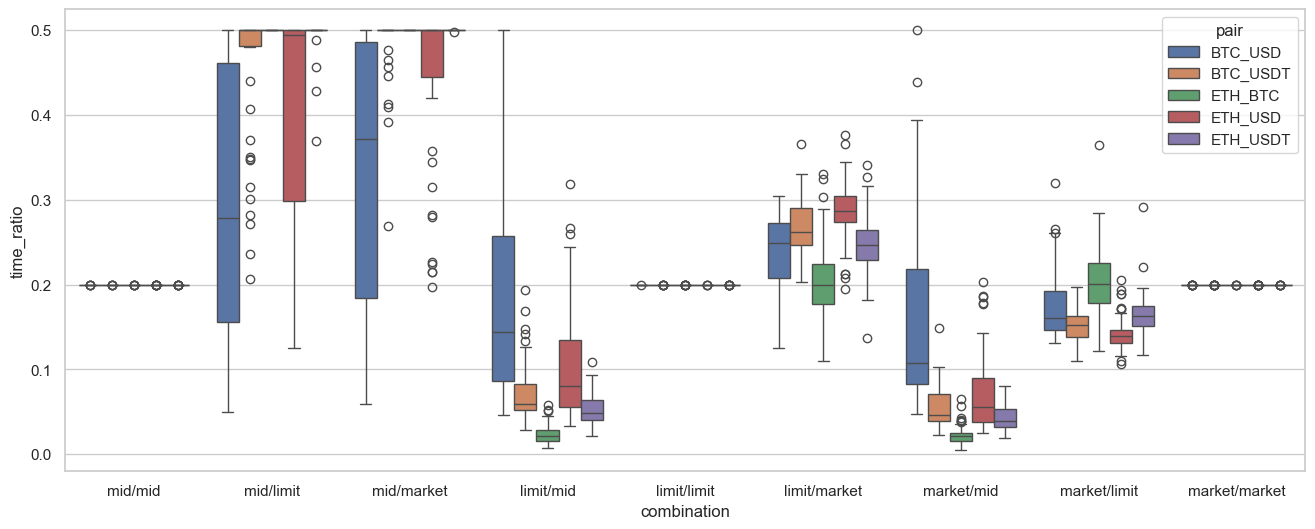

In [38]:
import itertools


def compute_all_event_time_ratios(group):
    # Create all pairs of rows within the group (with replacement, to include self-divisions)
    pairs = itertools.product(group.iterrows(), repeat=2)

    results = []
    for (idx1, row1), (idx2, row2) in pairs:
        results.append(
            {
                "pair": row1["pair"],
                "file": row1["file"],
                "type1": row1["event_type"],
                "type2": row2["event_type"],
                "time_ratio": min(
                    [
                        0.5,
                        (
                            0.2 * row1["event_time"] / row2["event_time"]
                            if row2["event_time"] != 0
                            else None
                        ),
                    ]
                ),
            }
        )
    return results


# Group by 'pair' and 'file' and apply the function
results = []
for _, group in count_df.groupby(["pair", "file"]):
    results.extend(compute_all_event_time_ratios(group))

# Convert results to a DataFrame
df_init = pd.DataFrame(results)
mapping_names = {
    "MID_PRICE_CHANGE": "mid",
    "MID_PRICE_LIMIT_ORDER_NOT_CHANGER": "limit",
    "MID_PRICE_MARKET_ORDER_NOT_CHANGER": "market",
}
df_init["combination"] = (
    df_init["type1"].map(mapping_names) + "/" + df_init["type2"].map(mapping_names)
)
df_init.head()

# boxplot of the time ratios
sns.set(style="whitegrid")
plt.figure(figsize=(16, 6))
sns.boxplot(x="combination", y="time_ratio", data=df_init, hue="pair")

In [52]:
def compute_spectral_radius(df):
    # Initialize a list to store spectral radius results
    spectral_radii = []

    # Group by 'file'
    for file, group in df.groupby("file"):
        # Reshape the 'rho' values into a 3x3 matrix for each file
        matrix = group["rho"].values.reshape(3, 3)

        # Compute the eigenvalues of the matrix
        eigenvalues = np.linalg.eigvals(matrix)

        # The spectral radius is the maximum absolute eigenvalue
        spectral_radius = np.max(np.abs(eigenvalues))

        # Append the result to the list
        spectral_radii.append({"file": file, "spectral_radius": spectral_radius})

    # Convert the list of results into a DataFrame
    return pd.DataFrame(spectral_radii)


# Compute the spectral radius for each file
spectral_radius_df = compute_spectral_radius(rho_df)
spectral_radius_df[spectral_radius_df["spectral_radius"] > 1]

,file,spectral_radius
0,orderbook_changes_1705356920082_1705353321,1.631824
1,orderbook_changes_1705356920082_1705355241,1.711633
2,orderbook_changes_1705364671663_1705361143,1.428610
3,orderbook_changes_1705364671663_1705363063,3.402751
4,orderbook_changes_1705371873937_1705368304,1.483438
...,...,...
245,orderbook_changes_1714386360800_1714377329,2.537306
246,orderbook_changes_1714386360800_1714379249,3.553785
247,orderbook_changes_1714422190487_1714418592,8.340199
248,orderbook_changes_1714422190487_1714420512,5.134723
